In [1]:
#Final
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CSV einlesen
df = pd.read_csv('../data/processed/china_model_dataset.csv')

# Historische Daten für später
historical_data = df[df['Year'] <= 2017]
years_historical = historical_data['Year'].values
true_total = historical_data['CO2_total'].values

# Ursprüngliche Features
base_features = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Rolling Average anwenden
df[base_features] = df[base_features].rolling(window=3, min_periods=1).mean()

# Lags erzeugen (Lag 1 & 2 für ausgewählte Features)
lag_features = ['GDP', 'Energy_intensity']
for col in lag_features:
    for lag in [1, 2]:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# NaNs entfernen
df.dropna(inplace=True)

# Input-Features aktualisieren
input_features = base_features + [f"{col}_lag{lag}" for col in lag_features for lag in [1, 2]]

# Zielvariablen
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Daten bis 2017
df_model = df[df['Year'] <= 2017].copy()

# Skalierung
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df_model[input_features])
y_scaled = target_scaler.fit_transform(df_model[target_columns])

# Fenstergröße
window_size = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - window_size):
    X_seq.append(X_scaled[i:i + window_size])
    y_seq.append(y_scaled[i + window_size])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/Test Split (zeitlich korrekt)
n_train = df_model[df_model['Year'] <= 2005].shape[0]
X_train = X_seq[:n_train - window_size]
y_train = y_seq[:n_train - window_size]
X_test = X_seq[n_train - window_size:]
y_test = y_seq[n_train - window_size:]

# Modell
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(window_size, len(input_features))))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=len(target_columns)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/500


C:\Users\belav\IdeaProjects\group14-co2-NetZeroTrackers\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0559 - mae: 0.1843 - val_loss: 0.2651 - val_mae: 0.4832
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - mae: 0.1094 - val_loss: 0.2182 - val_mae: 0.4362
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0142 - mae: 0.0898 - val_loss: 0.2616 - val_mae: 0.4838
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0761 - val_loss: 0.1965 - val_mae: 0.4130
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0572 - val_loss: 0.1326 - val_mae: 0.3257
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0496 - val_loss: 0.1057 - val_mae: 0.2657
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0573 - val_loss: 0.0978 - val_mae: 0.2728
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0661 - val_loss: 0.0977 - val_mae: 0.2647
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0467 - val_loss: 0

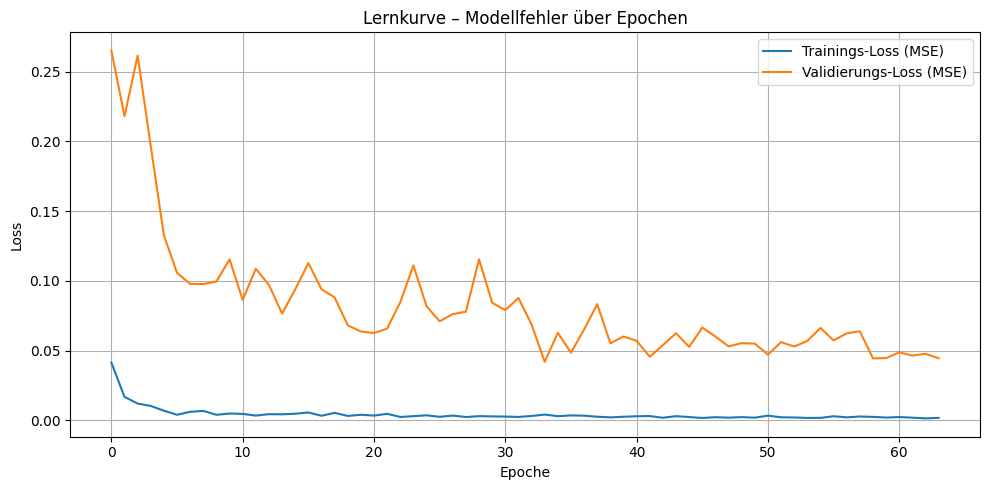

In [6]:
# Plot der Lernkurven (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Trainings-Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validierungs-Loss (MSE)')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Lernkurve – Modellfehler über Epochen')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# Vorhersage auf dem Testdatensatz (skaliert)
y_pred_scaled = model.predict(X_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Fehler-Metriken pro Zielvariable (CO₂-Komponenten)
for i, col in enumerate(target_columns):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])

    print(f"{col}:")
    print(f"  Mittlere absolute Abweichung (MAE): {mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Bestimmtheitsmaß (R²): {r2:.3f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
CO2_coal:
  Mittlere absolute Abweichung (MAE): 1025.19
  Root Mean Squared Error (RMSE): 1149.13
  Bestimmtheitsmaß (R²): -0.692

CO2_oil:
  Mittlere absolute Abweichung (MAE): 24.50
  Root Mean Squared Error (RMSE): 32.42
  Bestimmtheitsmaß (R²): 0.964

CO2_gas:
  Mittlere absolute Abweichung (MAE): 141.78
  Root Mean Squared Error (RMSE): 178.09
  Bestimmtheitsmaß (R²): -1.199

CO2_cement:
  Mittlere absolute Abweichung (MAE): 46.36
  Root Mean Squared Error (RMSE): 55.96
  Bestimmtheitsmaß (R²): 0.700



In [3]:
# Zeitraum 2013–2017 extrahieren
trend_df = df[(df['Year'] >= 2013) & (df['Year'] <= 2017)].reset_index(drop=True)

# Spalten, für die die Wachstumsrate berechnet werden soll
columns_to_analyze = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Wachstumsraten berechnen
trend_results = []
for col in columns_to_analyze:
    start_value = trend_df.iloc[0][col]
    end_value = trend_df.iloc[-1][col]
    n_years = trend_df.iloc[-1]['Year'] - trend_df.iloc[0]['Year']
    growth_rate = (end_value / start_value) ** (1 / n_years) - 1
    trend_results.append({
        'Feature': col,
        'Startwert': start_value,
        'Endwert': end_value,
        'Jahreswachstum': growth_rate
    })

# In DataFrame umwandeln und runden
trend_table = pd.DataFrame(trend_results)
trend_table['Jahreswachstum'] = (trend_table['Jahreswachstum'] * 100).round(3)  # in Prozent
trend_table = trend_table.round(2)

# Tabelle anzeigen
print(trend_table)

# Wachstumsraten als Dictionary (dezimal)
growth = dict(zip(trend_table['Feature'], (trend_table['Jahreswachstum'] / 100).values))

                 Feature     Startwert       Endwert  Jahreswachstum
0                    GDP  1.479672e+13  1.958043e+13            7.25
1             Population  1.369593e+09  1.404181e+09            0.62
2         Primary_energy  3.260442e+04  3.568769e+04            2.28
3       Energy_intensity  2.210000e+00  1.830000e+00           -4.63
4               CO2_coal  7.493410e+03  7.163260e+03           -1.12
5                CO2_oil  1.234620e+03  1.430590e+03            3.75
6                CO2_gas  3.201300e+02  4.863600e+02           11.02
7             CO2_cement  7.483200e+02  7.534400e+02            0.17
8   Urban_population_pct  5.176000e+01  5.673000e+01            2.32
9        Trade_share_GDP  4.842000e+01  3.810000e+01           -5.82
10     GDP_growth_annual  8.380000e+00  6.830000e+00           -4.98


In [4]:
import os

# Zielvariablen definieren
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Prognosezeitraum
future_years = list(range(2018, 2051))

# Wachstumsraten für BAU
growth = {
    'GDP': 0.0702,
    'Population': 0.0060,
    'Primary_energy': 0.0200,
    'Energy_intensity': -0.0470,
    'Urban_population_pct': 0.0226,
    'Trade_share_GDP': -0.0508,
    'GDP_growth_annual': -0.0289,
    'CO2_coal': -0.0112,
    'CO2_oil': 0.0375,
    'CO2_cement': 0.0017,
    'CO2_gas': 0.1102
}

# Letzter bekannter Datenpunkt (2017)
last_row = df_model[input_features + target_columns].iloc[-1].copy()
last_row['Year'] = 2017
last_row['CO2_total'] = last_row['CO2_coal'] + last_row['CO2_oil'] + last_row['CO2_gas'] + last_row['CO2_cement']

bau = last_row.copy()
measures = last_row.copy()

bau_rows = []
measure_rows = []

# Iteration über Zieljahre
for year in future_years:
    # BAU – normales Wachstum
    row_bau = bau.copy()
    row_bau['Year'] = year
    for key in growth:
        if key in row_bau:
            row_bau[key] *= (1 + growth[key])

    # Maßnahmen – direkte Eingriffe
    row_mea = measures.copy()
    row_mea['Year'] = year

    # Allgemeine wirtschaftliche Variablen (etwas abgeschwächt)
    row_mea['GDP'] *= 1.02
    row_mea['Population'] *= 1.006
    row_mea['Urban_population_pct'] *= 1.0226
    row_mea['Trade_share_GDP'] *= 0.9492
    row_mea['Primary_energy'] *= 0.98  # optionaler Rückgang

    # CO₂-Eingriffe
    if year >= 2018:
        row_mea['CO2_coal'] *= (1 - 0.02)  # -2 %/Jahr ab 2018

    if year >= 2025:
        row_mea['CO2_oil'] *= (1 - 0.015)  # -1.5 %/Jahr
        base_energy_intensity = row_mea['Energy_intensity'] / (1 + growth['Energy_intensity'])
        row_mea['Energy_intensity'] = base_energy_intensity * (1 - 0.06)  # -6 %/Jahr
        base_cement = row_mea['CO2_cement'] / (1 + growth['CO2_cement'])
        row_mea['CO2_cement'] = base_cement * (1 - 0.005)  # -0.5 %/Jahr

    if year >= 2030:
        base_gas = row_mea['CO2_gas'] / (1 + growth['CO2_gas'])
        row_mea['CO2_gas'] = base_gas * (1 + 0.005)  # leicht +0.5 % pro Jahr

    # CO2_total jeweils berechnen
    row_bau['CO2_total'] = row_bau['CO2_coal'] + row_bau['CO2_oil'] + row_bau['CO2_gas'] + row_bau['CO2_cement']
    row_mea['CO2_total'] = row_mea['CO2_coal'] + row_mea['CO2_oil'] + row_mea['CO2_gas'] + row_mea['CO2_cement']

    # Speichern
    bau_rows.append(row_bau.copy())
    measure_rows.append(row_mea.copy())

    # Update für nächste Iteration
    bau = row_bau.copy()
    measures = row_mea.copy()

# DataFrames erzeugen
df_bau_direct = pd.DataFrame(bau_rows)
df_mea_direct = pd.DataFrame(measure_rows)

# Vorschau
print("\nSzenario A – Business as Usual (direkte Entwicklung):")
df_bau_direct['Year'] = df_bau_direct['Year'].astype(int)
print(df_bau_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

print("\nSzenario B – Mit Maßnahmen (direkte Eingriffe):")
df_mea_direct['Year'] = df_mea_direct['Year'].astype(int)
print(df_mea_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

# Ergebnisordner erstellen und speichern
output_folder = '../data/results/szenario_prognose_china_lsmt/'
os.makedirs(output_folder, exist_ok=True)

df_bau_direct.to_csv(os.path.join(output_folder, 'china_bau.csv'), index=False)
df_mea_direct.to_csv(os.path.join(output_folder, 'china_measures.csv'), index=False)

print(f"\n Prognosedateien gespeichert in: {output_folder}")


Szenario A – Business as Usual (direkte Entwicklung):
 Year    CO2_total    CO2_coal     CO2_oil      CO2_gas  CO2_cement
 2018  9861.936165 7083.026544 1484.234013   539.955762  754.719846
 2019  9899.051191 7003.696647 1539.892788   599.458887  756.002870
 2020  9945.701343 6925.255244 1597.638768   665.519256  757.288075
 2021 10002.677550 6847.692386 1657.550221   738.859478  758.575465
 2022 10070.853421 6770.998231 1719.708355   820.281793  759.865043
 2023 10151.194128 6695.163051 1784.197418   910.676846  761.156814
 2024 10244.766260 6620.177224 1851.104821  1011.033435  762.450780
 2025 10352.748757 6546.031240 1920.521252  1122.449319  763.746946
 2026 10476.445039 6472.715690 1992.540799  1246.143234  765.045316
 2027 10617.296464 6400.221274 2067.261079  1383.468218  766.345893
 2028 10776.897262 6328.538796 2144.783369  1535.926416  767.648681
 2029 10957.011098 6257.659161 2225.212746  1705.185507  768.953684
 2030 11159.589457 6187.573379 2308.658224  1893.096950  770.

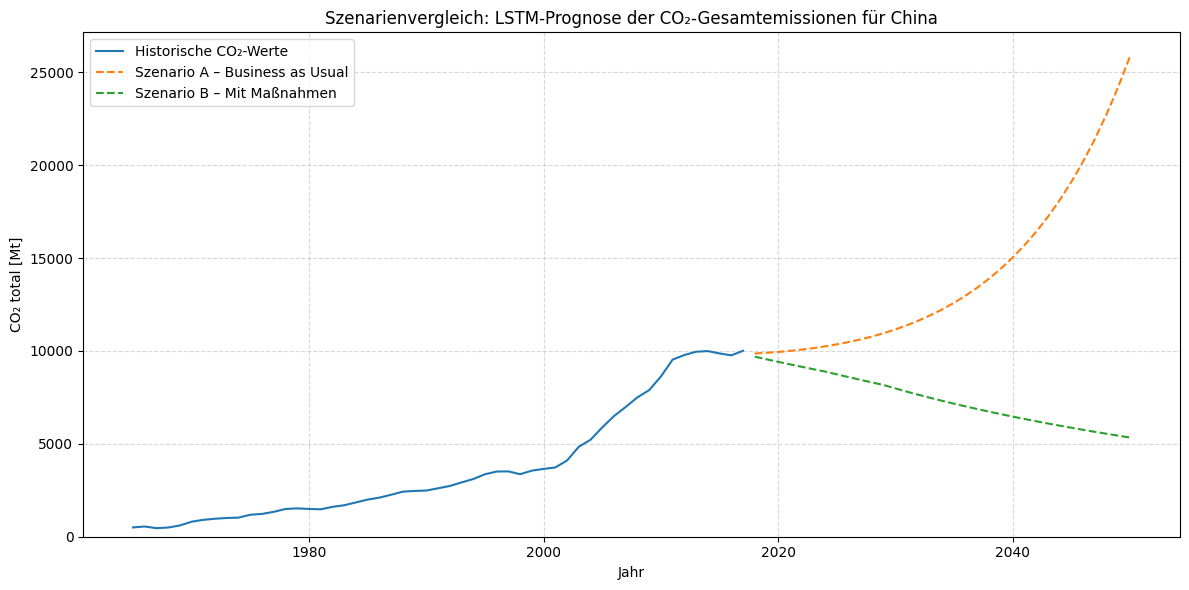

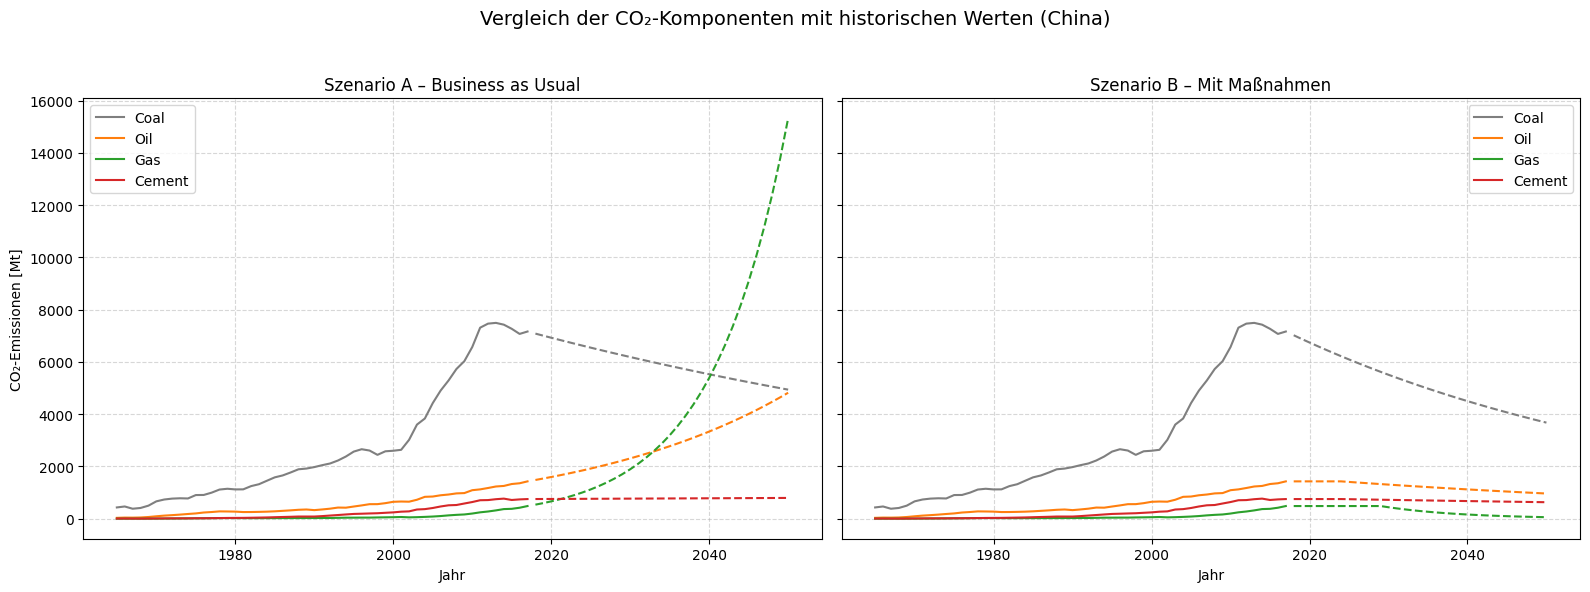

In [5]:
# Plot-Stil
plt.figure(figsize=(12, 6))

# Historische Daten bis 2017
plt.plot(historical_data['Year'], historical_data['CO2_total'], label='Historische CO₂-Werte', color='tab:blue')

# Prognose – BAU
plt.plot(df_bau_direct['Year'], df_bau_direct['CO2_total'], linestyle='--', color='tab:orange', label='Szenario A – Business as Usual')

# Prognose – Maßnahmen
plt.plot(df_mea_direct['Year'], df_mea_direct['CO2_total'], linestyle='--', color='tab:green', label='Szenario B – Mit Maßnahmen')

# Titel und Achsenbeschriftungen
plt.title('Szenarienvergleich: LSTM-Prognose der CO₂-Gesamtemissionen für China')
plt.xlabel('Jahr')
plt.ylabel('CO₂ total [Mt]')

# Legende
plt.legend()

# Achsenbegrenzung optional
plt.ylim(bottom=0)

# Raster
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Farben pro Komponente – konsistent
colors = {
    'CO2_coal': 'tab:gray',
    'CO2_oil': 'tab:orange',
    'CO2_gas': 'tab:green',
    'CO2_cement': 'tab:red'
}

# Historische Daten extrahieren
historical_co2 = historical_data[['Year', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']]

# Subplots: 1 Zeile, 2 Spalten
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 1. Plot – Business as Usual
for col in colors.keys():
    # Historische Werte
    axes[0].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[0].plot(df_bau_direct['Year'], df_bau_direct[col], linestyle='--', color=colors[col])

axes[0].set_title('Szenario A – Business as Usual')
axes[0].set_xlabel('Jahr')
axes[0].set_ylabel('CO₂-Emissionen [Mt]')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# 2. Plot – Mit Maßnahmen
for col in colors.keys():
    # Historische Werte
    axes[1].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[1].plot(df_mea_direct['Year'], df_mea_direct[col], linestyle='--', color=colors[col])

axes[1].set_title('Szenario B – Mit Maßnahmen')
axes[1].set_xlabel('Jahr')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Layout und Titel
plt.suptitle('Vergleich der CO₂-Komponenten mit historischen Werten (China)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()